In [1]:
import pandas as pd
import numpy as np

## Step 1. Scrape data from Wiki and transform it into a cleaned-up dataframe

In [3]:
!wget -q -O toronto.csv https://www.dropbox.com/s/1skvw8x5shxve6m/Toronto%20data.csv?dl=0

In [4]:
toronto_df = pd.read_csv ('toronto.csv')
toronto_df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [5]:
toronto_df.replace('Not assigned',np.nan, inplace=True)

In [6]:
for index, row in toronto_df.iterrows():
    if row['Neighbourhood'] is np.nan:
        row['Neighbourhood'] = row['Borough']
        

In [7]:
toronto_df.dropna(axis=0,how='any',inplace=True)

In [8]:
grouped_toronto = toronto_df.groupby('Postcode')['Neighbourhood'].apply(','.join).reset_index()

In [183]:
grouped_toronto.head()

,Postcode,Neighbourhood
0,M1B,"Rouge,Malvern"
1,M1C,"Highland Creek,Rouge Hill,Port Union"
2,M1E,"Guildwood,Morningside,West Hill"
3,M1G,Woburn
4,M1H,Cedarbrae


## Step 2: Obtain the latitude and longitude of each postal region

In [10]:
#!conda install -c conda-forge geocoder
#import geocoder

In [11]:
'''
Attempting to using geocoder to get latitude and longitude for each point, but it took too long for each point, so I switched to method B (see below)

for index, row in grouped_toronto.iterrows():
    print(index)
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.google('{}, Toronto, Ontario'.format(row['Postcode']))
        lat_lng_coords = g.latlng
    row['latitude'] = lat_lng_coords[0]
    row['longitude'] = lat_lng_coords[1]
    
    '''

"\nAttempting to using geocoder to get latitude and longitude for each point, but it took too long for each point, so I switched to method B (see below)\n\nfor index, row in grouped_toronto.iterrows():\n    print(index)\n    lat_lng_coords = None\n    while(lat_lng_coords is None):\n        g = geocoder.google('{}, Toronto, Ontario'.format(row['Postcode']))\n        lat_lng_coords = g.latlng\n    row['latitude'] = lat_lng_coords[0]\n    row['longitude'] = lat_lng_coords[1]\n    \n    "

In [12]:
!wget -q -O lat_long.csv https://cocl.us/Geospatial_data

In [13]:
lat_long_df = pd.read_csv ('lat_long.csv')
lat_long_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [14]:
merged_df = grouped_toronto.merge(lat_long_df, how='inner', left_on='Postcode',right_on='Postal Code').drop('Postal Code',axis=1)


In [185]:
merged_df.head()

,Postcode,Neighbourhood,Latitude,Longitude
0,M1B,"Rouge,Malvern",43.806686,-79.194353
1,M1C,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Woburn,43.770992,-79.216917
4,M1H,Cedarbrae,43.773136,-79.239476


## Step 3: Segment and clustering the neighborhoods in Toronto

In [17]:
import requests
import json
from pandas.io.json import json_normalize

### a. First define foursquare credentials and version

In [18]:
CLIENT_ID = 'UWQMLMUR3I1YWENTM4TYVCWHWNGINNU4L2SDG4LTFJECG2AO' # your Foursquare ID
CLIENT_SECRET = 'DSO5JAZPIRLRS4ALR2D3AJZIC4QWRZAEOOZP5QOGZ0Q0ACCS' # your Foursquare Secret
VERSION = '20190822' # Foursquare API version

In [46]:
radius = 500
LIMIT = 100

In [ ]:
venues_list = pd.Dataframe

for pc, lat, lng in zip(merged_df['Postcode'],merged_df['Latitude'],merged_df['Longitude']):
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    results = requests.get(url).json()['response']['venues']
    for v in results:
        if len(v['categories'])==0:
            venues_list.append([pc,lat,lng,None])
        else:
            venues_list.append([pc,lat,lng,v['categories'][0]['name']])

### b. Get the occurence frequencies of different venues at all postcodes

In [92]:
venues_df = pd.DataFrame(venues_list,columns=['Postcode','Latitude','Longitude','Venues'])

In [101]:
one_hot = pd.get_dummies(venues_df['Venues'])

In [117]:
merged_venues = venues_df.merge(one_hot,how='inner',left_index = True, right_index = True).drop(columns=['Latitude','Longitude','Venues'])

In [152]:
merged_venues.shape

(9883, 497)

In [202]:
grouped_venues_df = merged_venues.groupby('Postcode').mean().reset_index()
grouped_venues_df.shape

(103, 497)

### c. Cluster regions based on the venue occurences

In [203]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from geopy.geocoders import Nominatim
import matplotlib.cm as cm 

In [204]:
cluster_data = grouped_venues_df.loc[:,'ATM':]

In [161]:
K = []
SSD = []
for k in range(1,11):
    k_means = KMeans (n_clusters = k, init = 'k-means++', random_state = 0, n_init = 12)
    k_means.fit (cluster_data)
    K.append(k)
    SSD.append(k_means.inertia_)

Text(0, 0.5, 'sum of squared distance')

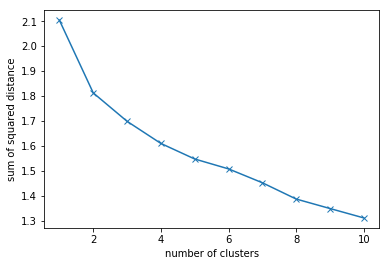

In [162]:
plt.plot(K,SSD,'-x')
plt.xlabel('number of clusters')
plt.ylabel('sum of squared distance')

From the graph above, I decide to form 8 clusters

In [167]:
k_means = KMeans (n_clusters=8 , init = 'k-means++', random_state = 0, n_init = 12)
k_means.fit (cluster_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=12, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [181]:
grouped_venues_df['cluster']= k_means.labels_

In [190]:
venues_clusters_df = grouped_venues_df.merge(merged_df, how = 'inner', on ='Postcode')
venues_clusters_df.head()

,Postcode,ATM,Accessories Store,Acupuncturist,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,...,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio,Zoo,Zoo Exhibit,cluster,Neighbourhood,Latitude,Longitude
0,M1B,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.01,2,"Rouge,Malvern",43.806686,-79.194353
1,M1C,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,...,0.0,0.0,0.0,0.01,0.0,0.00,0,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0,Woburn,43.770992,-79.216917
4,M1H,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,2,Cedarbrae,43.773136,-79.239476


## d. Map out the clustered neighborhoods on the map

In [179]:
!conda install -c conda-forge folium=0.5.0
import folium

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    certifi-2019.6.16          |           py36_1         149 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    altair-3.2.0               |           py36_0         770 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.3 MB

The following NEW packages will be 

In [175]:
address = 'Toronto,Canada'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [195]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)


kclusters = 8
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for lat, lon, poi, cluster in zip(venues_clusters_df['Latitude'], venues_clusters_df['Longitude'], venues_clusters_df['Postcode'], venues_clusters_df['cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_toronto)
       
map_toronto
